# IMPORTS

In [1]:
%load_ext blackcellmagic

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from plotly import express as px

import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance

# Functions and Setups

In [3]:
color_pal = sns.color_palette('pastel') # https://seaborn.pydata.org/tutorial/color_palettes.html
plt.style.use('fivethirtyeight')

In [4]:
def create_features(df: pd.DataFrame) -> pd.DataFrame:
    """Create time series features based on time series index.

    Args:
        df (pd.DataFrame): source DataFrame

    Returns:
        pd.DataFrame: modified DataFrame
    """
    df = df.copy()
    df["hour"] = df.index.hour
    df["dayofweek"] = df.index.dayofweek
    df["quarter"] = df.index.quarter
    df["month"] = df.index.month
    df["year"] = df.index.year
    df["dayofyear"] = df.index.dayofyear
    df["dayofmonth"] = df.index.day
    df["weekofyear"] = df.index.isocalendar().week
    return df

In [5]:
def get_usa_season(date: pd.Timestamp, return_type: str = "txt") -> str:
    """Return season in USA from date.

    Args:
        date (pd.Timestamp): date as pandas Timestamp format.

    Returns:
        str: season; One of ['Winter', 'Spring', 'Summer', 'Fall'] or `None` if invalid.
    """
    # Create a dictionary mapping seasons to their respective month ranges
    if return_type == "txt":
        seasons = {
            "Winter": ((1, 1), (3, 20)),
            "Spring": ((3, 21), (6, 20)),
            "Summer": ((6, 21), (9, 22)),
            "Fall": ((9, 23), (12, 20)),
            "Winter": ((12, 21), (12, 31)),
        }
    elif return_type == "number":
        seasons = {
            0: ((1, 1), (3, 20)),
            1: ((3, 21), (6, 20)),
            2: ((6, 21), (9, 22)),
            3: ((9, 23), (12, 20)),
            0: ((12, 21), (12, 31)),
        }
    else:
        raise ValueError(f"""Check input of `return_type`. Only expects one of these ["txt", "number"]""")
        
    # Convert date to a Pandas Timestamp object if it's not already
    if not isinstance(date, pd.Timestamp):
        date = pd.to_datetime(date)

    # Iterate over the seasons and check if the date falls within any range
    for season, (start_month_day, end_month_day) in seasons.items():
        start_month, start_day = start_month_day
        end_month, end_day = end_month_day

        if (
            (date.month == start_month and date.day >= start_day)
            or (date.month == end_month and date.day <= end_day)
            or (start_month < date.month < end_month)
        ):
            return season

    return None

# def convert_days_to_season(days):
#     # Define the start day and length of each season
#     spring_start = 80  # March 21st (approximate)
#     summer_start = 172  # June 21st (approximate)
#     fall_start = 264  # September 23rd (approximate)
#     winter_start = 355  # December 21st (approximate)

#     # Determine the season based on the given number of days
#     if days >= spring_start and days < summer_start:
#         season = "Spring"
#     elif days >= summer_start and days < fall_start:
#         season = "Summer"
#     elif days >= fall_start and days < winter_start:
#         season = "Fall"
#     else:
#         season = "Winter"

#     return season

# OBTAIN

About Dataset
PJM Hourly Energy Consumption Data

PJM Interconnection LLC (PJM) is a regional transmission organization (RTO) in the United States. It is part of the Eastern Interconnection grid operating an electric transmission system serving all or parts of Delaware, Illinois, Indiana, Kentucky, Maryland, Michigan, New Jersey, North Carolina, Ohio, Pennsylvania, Tennessee, Virginia, West Virginia, and the District of Columbia.

The hourly power consumption data comes from PJM's website and are in megawatts (MW).

The regions have changed over the years so data may only appear for certain dates per region.

In [6]:
df = pd.read_csv('./data/PJM/PJME_hourly.csv')
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

In [7]:
df.head(3)

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0


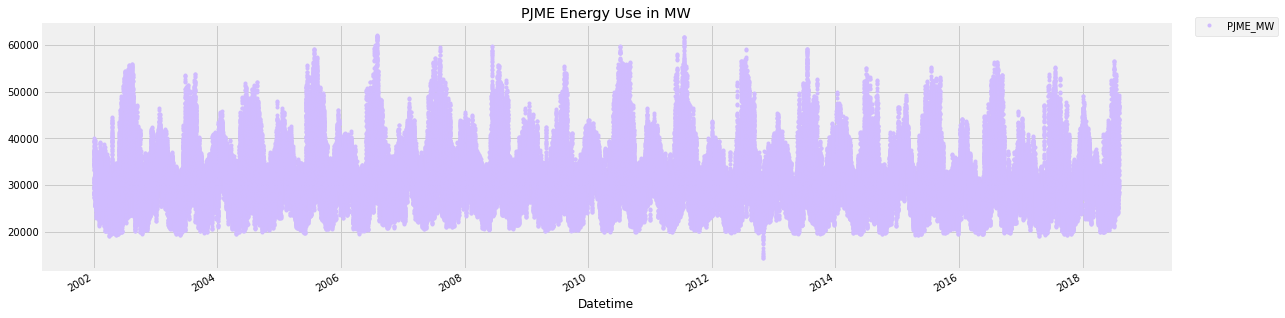

In [8]:
ax = df.plot(
    style=".", figsize=(18, 5), color=color_pal[4], title="PJME Energy Use in MW"
)
ax.legend(bbox_to_anchor=(1.1, 1.05))
plt.show()

In [9]:
# px.line(data_frame=df, title="PJME Energy Use in MW")

# SCRUB

## EDA

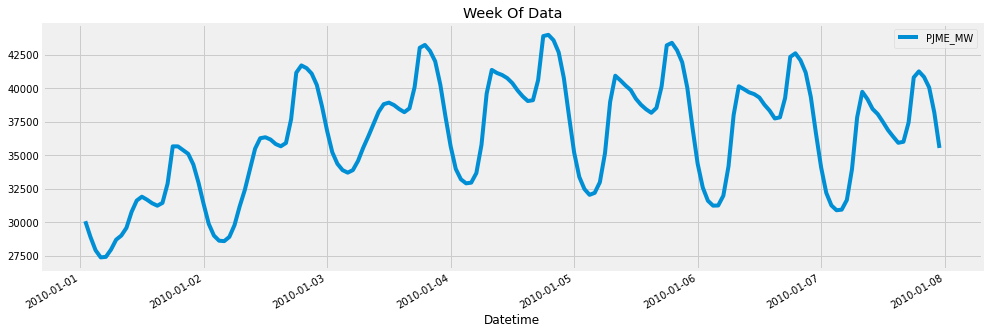

In [10]:
df.loc[(df.index > "01-01-2010") & (df.index < "01-08-2010")].plot(
    figsize=(15, 5), title="Week Of Data"
)
plt.show()

## Feature Engineering

### Feature Creation

In [11]:
df = create_features(df)

### Feature / Target Relationship

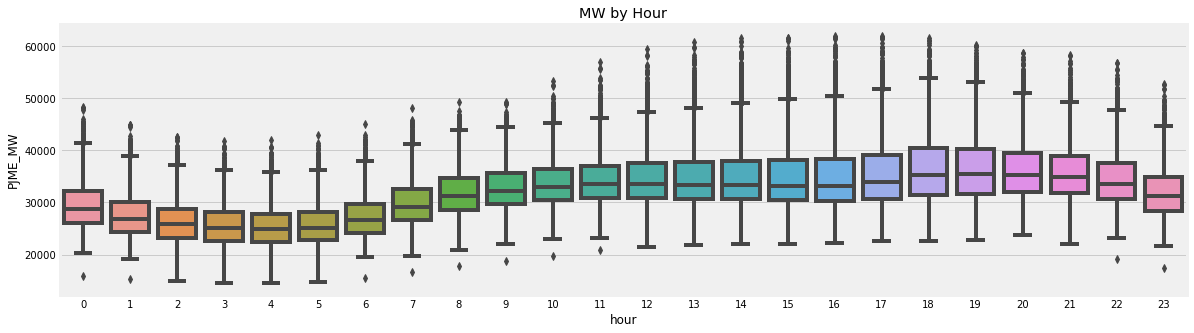

In [12]:
fig, ax = plt.subplots(figsize=(18, 5))
sns.boxplot(data=df, x='hour', y='PJME_MW')
ax.set_title('MW by Hour')
plt.show()

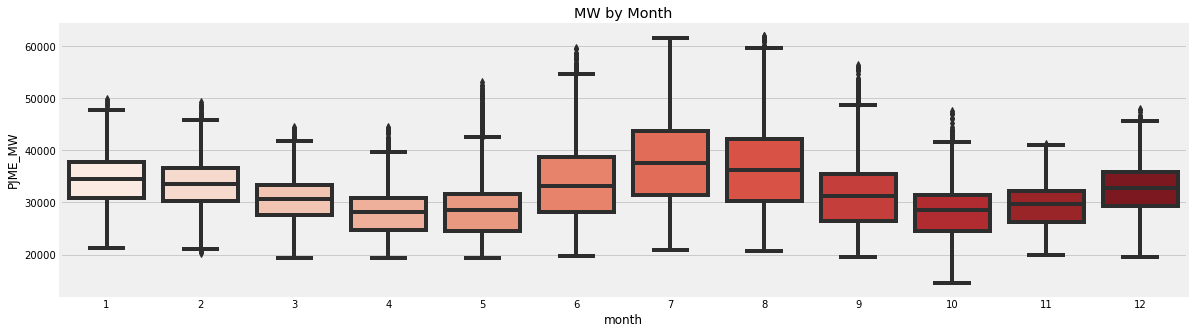

In [13]:
fig, ax = plt.subplots(figsize=(18, 5))
sns.boxplot(data=df, x='month', y='PJME_MW', palette='Reds')
ax.set_title('MW by Month')
plt.show()

In [14]:
_ = df.copy()
_.dayofweek = df.index.day_name()
_.month = df.index.month_name()
map_q = {1: "Q1", 2: "Q2", 3: "Q3", 4: "Q4"}
_.quarter = df["quarter"].map(map_q)
_["season"] = [get_usa_season(x) for x in df.index]

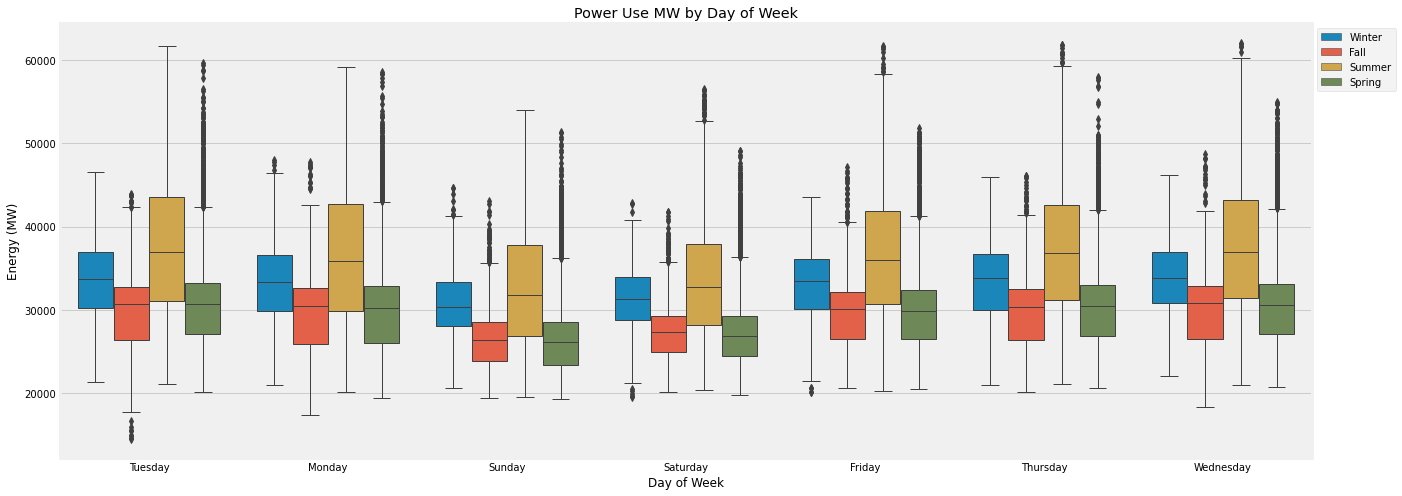

In [15]:
fig, ax = plt.subplots(figsize=(20, 8))

sns.boxplot(data=_.dropna(),
            x='dayofweek',
            y='PJME_MW',
            hue='season',
            ax=ax,
            linewidth=1)

ax.set_title('Power Use MW by Day of Week')
ax.set_xlabel('Day of Week')
ax.set_ylabel('Energy (MW)')
ax.legend(bbox_to_anchor=(1, 1))

plt.show()

# ML

## Preprocessing

### Train-Test Split

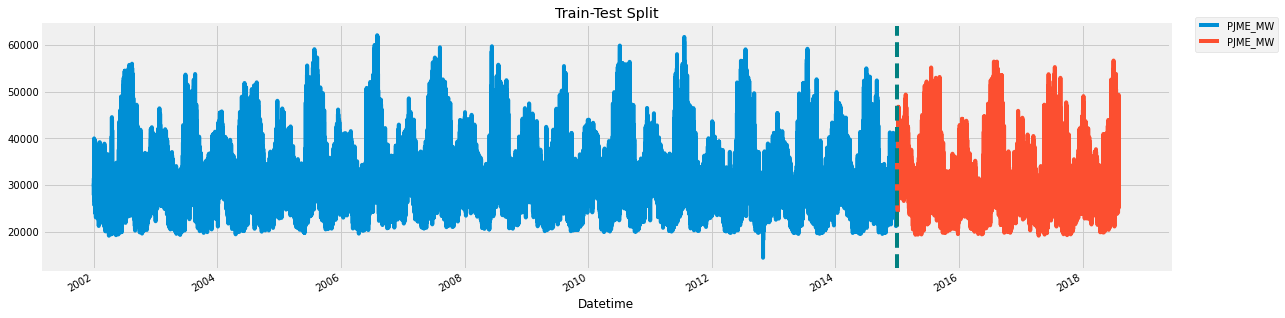

In [16]:
train = df.loc[df.index < '01-01-2015'][['PJME_MW']]
test = df.loc[df.index >= '01-01-2015'][['PJME_MW']]

fig, ax = plt.subplots(figsize=(18, 5))
train.plot(ax=ax, label='Training Set', title='Train-Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='teal', ls='--')
ax.legend(['Training Set', 'Test Set'])
ax.legend(bbox_to_anchor=(1.1, 1.05))
plt.show()

## Setup

In [17]:
train = create_features(train)
test = create_features(test)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'PJME_MW'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

## XGBoost

In [18]:
reg = xgb.XGBRegressor(
    base_score=0.5,
    booster="gbtree",
    n_estimators=10_000,
    early_stopping_rounds=50,
    objective="reg:squarederror",# "reg:linear",
    max_depth=3,
    learning_rate=0.01,
)

In [19]:
reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=50)

[0]	validation_0-rmse:32605.13860	validation_1-rmse:31657.15907


[50]	validation_0-rmse:20059.24001	validation_1-rmse:19150.56352
[100]	validation_0-rmse:12581.21576	validation_1-rmse:11743.75117
[150]	validation_0-rmse:8240.15270	validation_1-rmse:7542.65491
[200]	validation_0-rmse:5835.12473	validation_1-rmse:5365.67712
[250]	validation_0-rmse:4555.00578	validation_1-rmse:4369.55165
[300]	validation_0-rmse:3915.75572	validation_1-rmse:4020.67027
[350]	validation_0-rmse:3609.10659	validation_1-rmse:3896.09103
[400]	validation_0-rmse:3443.16487	validation_1-rmse:3853.40425
[450]	validation_0-rmse:3348.70750	validation_1-rmse:3825.60470
[500]	validation_0-rmse:3285.33827	validation_1-rmse:3805.30193
[550]	validation_0-rmse:3239.43012	validation_1-rmse:3786.43277
[600]	validation_0-rmse:3201.92939	validation_1-rmse:3772.44905
[650]	validation_0-rmse:3172.98442	validation_1-rmse:3762.19551
[700]	validation_0-rmse:3148.14225	validation_1-rmse:3750.91088
[750]	validation_0-rmse:3128.16688	validation_1-rmse:3741.50617
[800]	validation_0-rmse:3109.24250	va

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=50, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=10000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

### Inference

#### Feature Importance

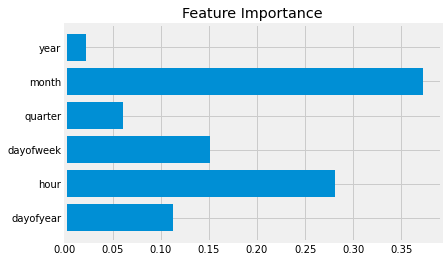

In [20]:
plt.barh(reg.feature_names_in_, reg.feature_importances_)
plt.title(label="Feature Importance")
plt.show()


In [21]:
perm_importance = permutation_importance(reg, X_test, y_test)

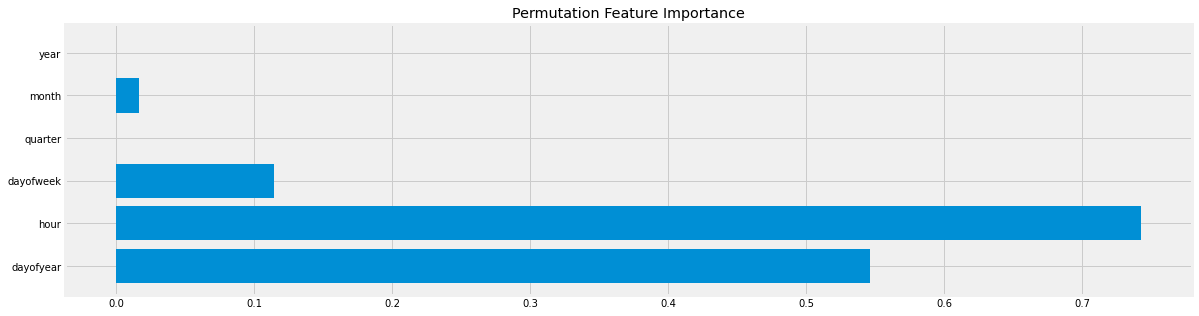

In [22]:
fig, ax = plt.subplots(figsize=(18, 5))
plt.barh(reg.feature_names_in_, perm_importance.importances_mean)
plt.title(label="Permutation Feature Importance")
plt.show()

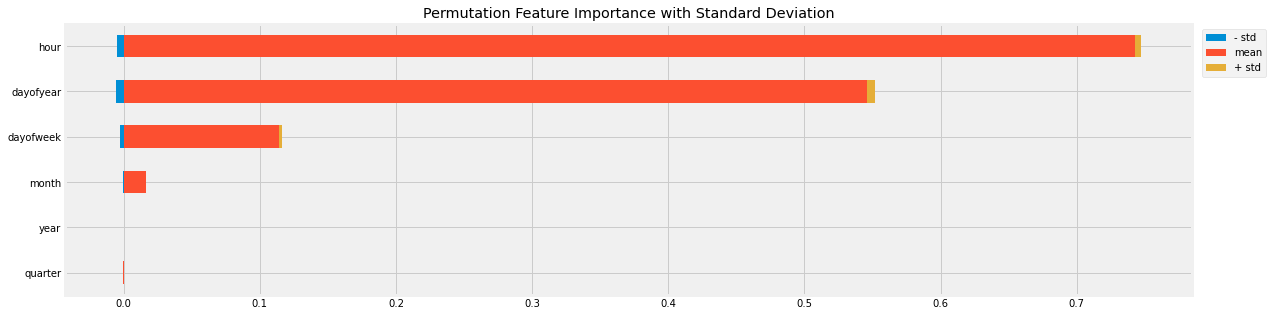

In [23]:
_ = pd.DataFrame(
    [
        reg.feature_names_in_,
        -perm_importance.importances_std,
        perm_importance.importances_mean,
        perm_importance.importances_std,
    ]
)
_ = _.T
_.set_index(0, inplace=True)
_.columns = ["- std", "mean", "+ std"]
_.sort_values(by=["mean"], axis='index', ascending=True, inplace=True)
ax = _.plot(kind="barh", stacked=True, figsize=(18, 5))
plt.title(label="Permutation Feature Importance with Standard Deviation")
ax.set(ylabel=None)
ax.legend(bbox_to_anchor=(1.07, 1))
plt.show()

### Forecast on Test Dataset

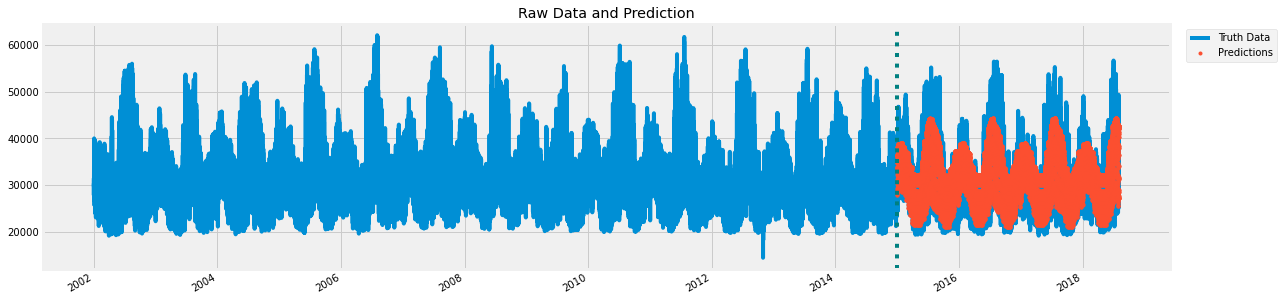

In [24]:
_test = test.copy()
_df = df.copy()
_test["prediction"] = reg.predict(X_test)
_df = _df.merge(_test[["prediction"]], how="left", left_index=True, right_index=True)

ax = _df[["PJME_MW"]].plot(figsize=(18, 5))
_df["prediction"].plot(ax=ax, style=".")
plt.legend(["Truth Data", "Predictions"], bbox_to_anchor=(1.01, 1.0))
ax.set_title("Raw Data and Prediction")
ax.axvline("01-01-2015", color="teal", ls=":")
ax.set(xlabel=None)
plt.show()

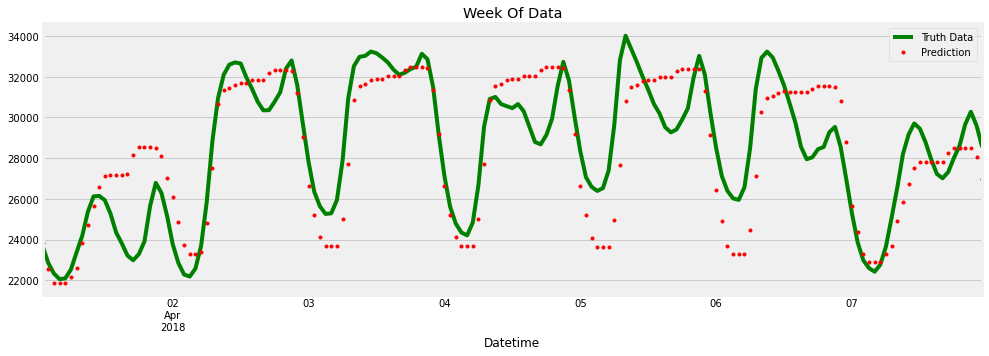

In [25]:
ax = _df.loc[(_df.index > "04-01-2018") & (_df.index < "04-08-2018")]["PJME_MW"].plot(
    figsize=(15, 5), title="Week Of Data", color="g"
)
_df.loc[(_df.index > "04-01-2018") & (_df.index < "04-08-2018")]["prediction"].plot(
    style=".", color="r"
)
plt.legend(["Truth Data", "Prediction"])
plt.show()

## Model Performance

### RMSE

In [26]:
score = np.sqrt(mean_squared_error(_test["PJME_MW"], _test["prediction"]))
print(f"RMSE Score on Test set: {score:0.2f}")

RMSE Score on Test set: 3721.75


### Error

In [27]:
_test["error"] = np.abs(_test[TARGET] - _test["prediction"])
_test["date"] = _test.index.date

print("Worst Predictions:")
print(
    _test.groupby(["date"])["error"]
    .mean()
    .sort_values(ascending=False)
    .head(10)
    .to_string()
)

print("\nBest Predictions:")
print(
    _test.groupby(["date"])["error"]
    .mean()
    .sort_values(ascending=True)
    .head(10)
    .to_string()
)

Worst Predictions:
date
2016-08-13    12839.595459
2016-08-14    12780.209554
2016-09-10    11356.302002
2015-02-20    10965.976237
2016-09-09    10864.953451
2018-01-06    10506.844889
2016-08-12    10124.050618
2015-02-21     9881.798503
2015-02-16     9781.549805
2018-01-07     9739.143555

Best Predictions:
date
2017-10-24    349.391520
2015-10-28    397.410563
2016-10-27    528.968994
2015-05-06    529.528483
2017-10-15    535.291748
2018-05-16    585.348470
2016-10-08    625.825521
2015-10-03    653.130697
2016-09-16    656.402588
2015-11-06    674.912516


# Next Steps
- try out different models
    - Prophet | NeuralProphet [*](https://www.kaggle.com/code/antonmurashko/time-series-forecasting-with-prophet-yt) [1](https://bobrupakroy.medium.com/yes-our-favorite-fbprophet-is-back-with-multivariate-forecasting-785fbe412731) [2](https://www.microprediction.com/blog/prophet)
    - ANN: LSTM
    - ARIMA models; and its extensions like SARIMA, SARIMAX
    - scikit-learn based NN
    - LightGBM
    - AutoARIMA
    - Tsfresh | Darts | Kats [1](https://www.analyticsvidhya.com/blog/2022/05/5-python-libraries-for-time-series-analysis/) [2](https://towardsdatascience.com/3-unique-python-packages-for-time-series-forecasting-2926a09aaf5b)
- More robust cross validation for models
- Add more features (weather forecast data, holidays, major events, season)

# Notes
- add holidays
```python
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
```

- alternative feature engineering. [source](https://www.kaggle.com/code/antonmurashko/time-series-forecasting-with-prophet-yt)
```python
from pandas.api.types import CategoricalDtype

cat_type = CategoricalDtype(categories=['Monday','Tuesday',
                                        'Wednesday',
                                        'Thursday','Friday',
                                        'Saturday','Sunday'],
                            ordered=True)

def create_features(df, label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['weekday'] = df['date'].dt.day_name()
    df['weekday'] = df['weekday'].astype(cat_type)
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    df['date_offset'] = (df.date.dt.month*100 + df.date.dt.day - 320)%1300

    df['season'] = pd.cut(df['date_offset'], [0, 300, 602, 900, 1300], 
                          labels=['Spring', 'Summer', 'Fall', 'Winter']
                   )
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear','weekday',
           'season']]
    if label:
        y = df[label]
        return X, y
    return X

X, y = create_features(pjme, label='PJME_MW')
features_and_target = pd.concat([X, y], axis=1)
```

# Disclaimer
This project is heavily influenced by [`ROB MULLA`](https://www.kaggle.com/code/robikscube/time-series-forecasting-with-machine-learning-yt). [[YouTube - p1](https://www.youtube.com/watch?v=vV12dGe_Fho), [Youtube - p2](https://www.youtube.com/watch?v=z3ZnOW-S550) as of June 17, 2023.]